# Optimización del modelo

**Autores:**

- José Antonio Nazar Alaez (jose.nazar@cunef.edu)


- Francisco Martínez García (f.martinezgarcia@cunef.edu)

En este notebook realizaremos la optimización del modelo que hemos elegido y la explicabilidad mediante shap

# Functions

In [1]:
def model_analysis_op(modelo, xtest, ytest):
    matplotlib.rcParams['figure.figsize'] = (9, 9)
    ypred = modelo.predict(xtest)
    ypred_proba = modelo.predict_proba(xtest)
    # keep probabilities for the positive outcome only
    yhat = ypred_proba[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(ytest, yhat)
    # plot the roc curve for the model
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=re.findall('^[A-z]+', str(modelo)))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()

    gmeans = np.sqrt(tpr * (1 - fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)

    # print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    # plot the roc curve for the model
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=re.findall('^[A-z]+', str(modelo)))
    plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    ypred_new_threshold = (ypred_proba[:, 1] > thresholds[ix]).astype(int)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred_new_threshold,
                                                       cmap=plt.cm.Greens,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

    evaluate_model(ytest, ypred_new_threshold, ypred_proba)
    
    com_gain(ytest, ypred_proba)
    
    lift_curve(ytest, ypred_proba)

    
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))
    print('F2 Score: \n{}\n'.format(fbeta_score(ytest, ypred,beta=2,average="macro")))
    
    
def com_gain(y_test, prob_predictions):
    skplt.metrics.plot_cumulative_gain(y_test, prob_predictions)
    plt.show() 
    
def lift_curve(ytest, prob_predictions):
    skplt.metrics.plot_lift_curve(ytest, prob_predictions)
    plt.show()

# Librerías

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import matplotlib
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix # Matriz confusion
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, fbeta_score
from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import re

In [3]:
#Read the traing data
pd_train = pd.read_parquet('./data/training_data.parquet')
pd_test = pd.read_parquet('./data/test_data.parquet')

#Obtain thre same training data as in the previous steps
X_train, X_validation, y_train, y_validation = train_test_split(pd_train, pd_train['punctuation'], 
                                                                test_size=0.15, 
                                                                random_state=12345)
X_train = X_train.drop(['punctuation'], axis=1)
#Divide test data in x and y
X_test = pd_test.drop(['punctuation'], axis=1)
y_test = pd_test['punctuation']

# Optimization

A continuación procedemos a optimizar el random forest que es el modelo que obtenía mejores resultados

In [4]:
with open('./models/preprocessor.pickle', 'rb') as f:
    preprocessor = pickle.load(f)

In [5]:
rf = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', RandomForestClassifier())])

### Parameter Tunning Optimization
param_grid = { 
    'clasificador__n_estimators': [100, 150, 400],
    'clasificador__max_features': ['sqrt', 'log2'],
    'clasificador__max_depth' : [4, 6, 8, None],
    'clasificador__criterion' :['gini'],
    'clasificador__class_weight':['balanced']}


CV = GridSearchCV(rf, param_grid, cv=2, n_jobs=5, scoring='roc_auc', verbose=1)

In [6]:
CV.fit(X_train, y_train)
print(CV.best_params_)
print(CV.best_score_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
{'clasificador__class_weight': 'balanced', 'clasificador__criterion': 'gini', 'clasificador__max_depth': None, 'clasificador__max_features': 'log2', 'clasificador__n_estimators': 400}
0.7727909883862372


Tras realizar la optimización hemos obtenido los mejores parámetros para el modelo random forest

In [7]:
with open('./models/Final_RandomForest.pickle', 'wb') as f:
    pickle.dump(CV, f)

In [8]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('./models/Final_RandomForest.pickle', 'rb') as f:
    CV = pickle.load(f)

In [9]:
print(CV.best_params_)
print(CV.best_score_)
ypred = CV.predict(X_test)

{'clasificador__class_weight': 'balanced', 'clasificador__criterion': 'gini', 'clasificador__max_depth': None, 'clasificador__max_features': 'log2', 'clasificador__n_estimators': 400}
0.7727909883862372


In [10]:
ypred_proba = CV.predict_proba(X_test)

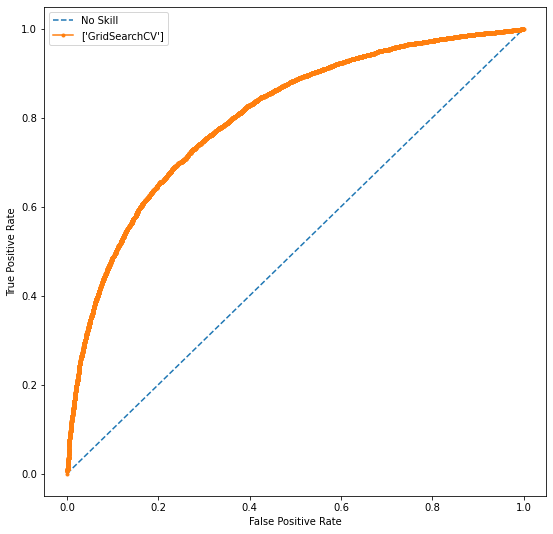

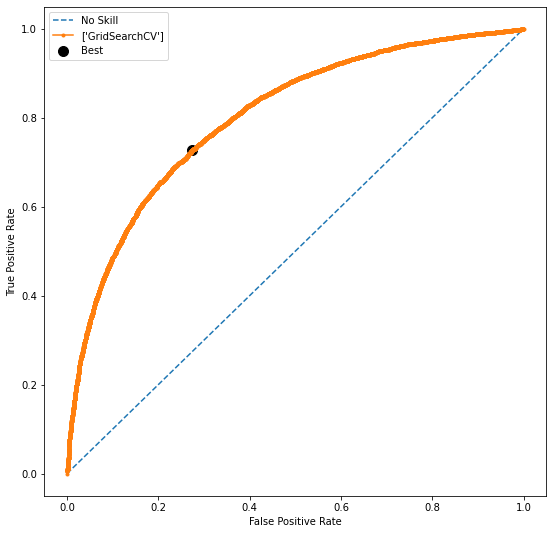

ROC-AUC score of the model: 0.8018644963212002
Accuracy of the model: 0.7262549257908887

Classification report: 
              precision    recall  f1-score   support

           0       0.72      0.73      0.73     13514
           1       0.73      0.73      0.73     13639

    accuracy                           0.73     27153
   macro avg       0.73      0.73      0.73     27153
weighted avg       0.73      0.73      0.73     27153


Confusion matrix: 
[[9811 3703]
 [3730 9909]]

F2 Score: 
0.7262525928067898



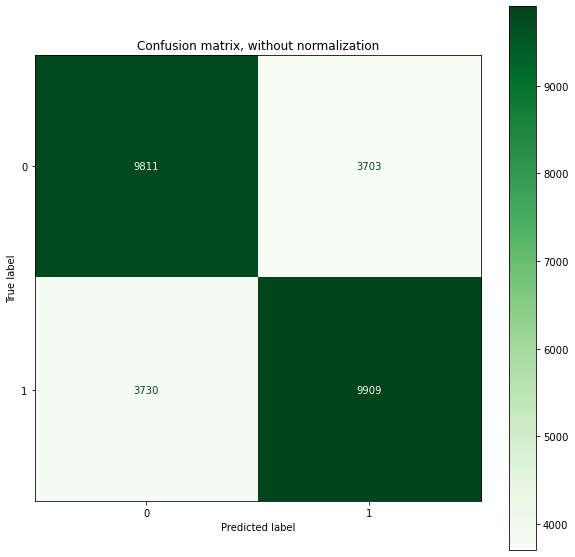

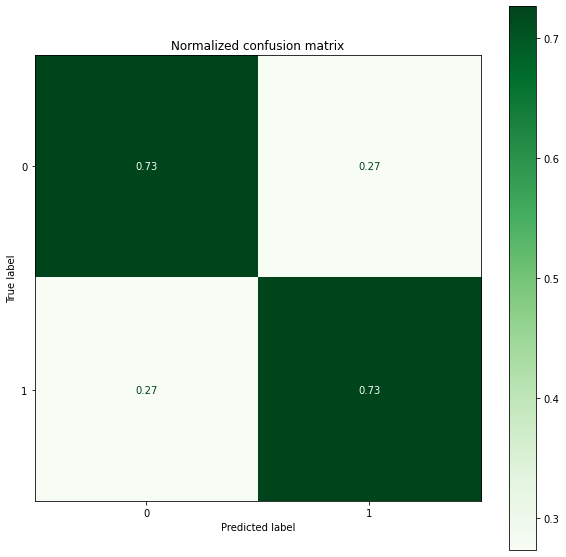

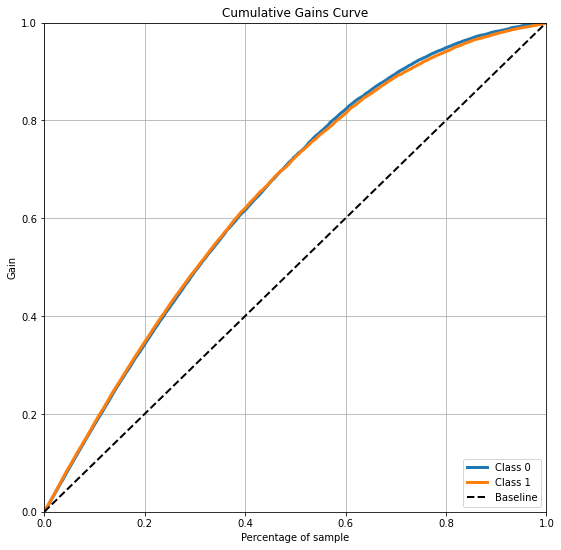

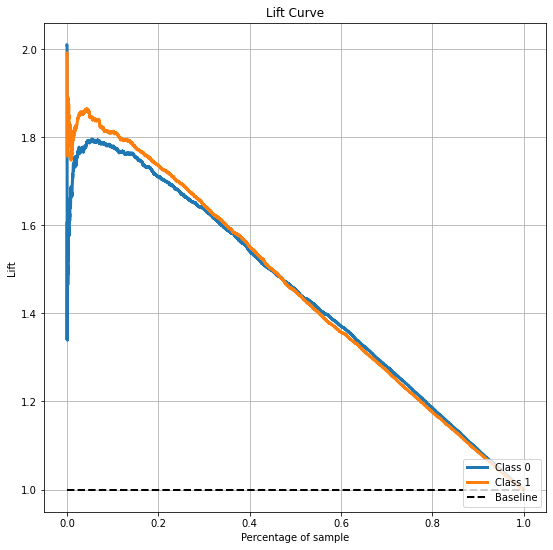

In [11]:
import scikitplot as skplt
model_analysis_op(CV, X_test, y_test)

# Explicación

A continuación incluimos el código de la explicabilidad con SHAP. La razón de que no lo hayamos analizado es que lleva 22 horas cargando y no se ejecuta. Por lo tanto, hemos decidido dejar el código comentado.

## Shap

In [12]:
# import shap#Create model

# shap.initjs()
# model = CV.best_estimator_.named_steps['clasificador']
# explainer = shap.TreeExplainer(model)

In [13]:
# #Execute model
# shap_values = explainer.shap_values(X_test)

In [14]:
# #Save model
# with open('./models/shap_values.pickle', 'wb') as f:
#     pickle.dump(shap_values, f)

In [15]:
# #Load model
# with open('./models/shap_values.pickle', 'rb') as f:
#     shap_values = pickle.load(f)

In [16]:
# base_value = explainer.expected_value

### Summary Plot polarized

In [17]:
# shap.summary_plot(shap_values[1], features=X_test, max_display=25)

### Summary Plot

In [18]:
# shap.summary_plot(shap_values, X_test)

In [19]:
# #One line explained
# shap.force_plot(explainer.expected_value[0], shap_values[1][20], X_test.iloc[20,:])